In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from typing import Tuple

# Root directory of the project
ROOT_DIR = os.path.abspath("/")

# Import Mask RCNN
sys.path.append(ROOT_DIR) # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [7]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.compat.v1.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 445277123794666785
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8175927225451379877
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13293722706231882164
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:-1][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape[0], shape[1], 1)

In [3]:
class GarbageDataset(utils.Dataset):
    def load_dataset(self, images_dir: str, csv: pd.DataFrame, indexes: Tuple[int, int], multcheck=False):
        # Definig classes
        self._csv = csv
        self.add_class("dataset", 1, "garbage")
        self.images_dir = images_dir
        
        # Defining images
        for i, image_name in enumerate(os.listdir(images_dir)):
            if i < indexes[0] or i >= indexes[1]:
                continue
                
            image_path = os.path.join(images_dir, image_name)
            height, width = self._get_resolution(image_name)
            
            if image_name not in csv['image'].values:
                print("Skipping", image_name)
                continue
            
            if multcheck and image_name in csv[csv['count'] > 1]['image'].values:
                print("Skipping due to multiplarity")
                continue
                
            self.add_image('dataset', image_id=image_name, path=image_path, height=height, width=width)
            
    def _get_resolution(self, image_path: str):
        with Image.open(self.images_dir + image_path) as img:
            width, height = img.size
        return (height, width)
        
    
    def _rle_to_mask(self, mask_rle, shape):
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:-1][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(shape).astype(bool)
    
    def load_masks(self, image_id):
        img_info = self.image_info[image_id]
        file_name = os.path.split(img_info['path'])[1]
        img_csv_data = self._csv[self._csv['image'] == file_name]
        rle = img_csv_data["rle"]
        masks = np.zeros((img_info['height'], img_info['width'], len(rle.values)))
        
        for i, rlestring in enumerate(rle.values):
            masks[:,:,i] = masks[:,:,i] + self._rle_to_mask(rlestring, (img_info['height'], img_info['width']))
        
        # Handle occlusions
        occlusion = np.logical_not(masks[:, :, -1]).astype(np.uint8)
        for i in range(len(rle.values)-2, -1, -1):
            masks[:, :, i] = masks[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(masks[:, :, i]))
            
        masks = masks.astype(bool)
        return masks, np.full(len(rle.values), self.class_names.index("garbage"))
        
    def load_mask(self, image_id):
#         img_info = self.image_info[image_id]
#         file_name = os.path.split(img_info['path'])[1]
#         img_csv_data = self._csv[self._csv['image'] == file_name]
        
#         rle = img_csv_data["rle"].values[0]
        
#         mask = rle_decode(rle, (img_info['height'], img_info['width']))
#         mask_count = img_csv_data["count"].values[0]
#         class_ids = np.full(1, self.class_names.index("garbage"))

#         return mask, class_ids
        return self.load_masks(image_id)
    
    def image_referece(self, image_id):
        return self.image_info[image_id]['path']
    

In [4]:
csv = pd.read_csv('./datasets/merged-train-all.csv')

image_folder = './datasets/train/train/'
train_indexes: Tuple[int, int] = (0, 1400) #starting index, ending index
validate_indexes: Tuple[int, int] = (1400, 1800)

train_set = GarbageDataset()
train_set.load_dataset(image_folder, csv, train_indexes)
train_set.prepare()

print('Train: %d' % len(train_set.image_ids))

Skipping DJI_0008-1000.jpg
Skipping DJI_0008-1325.jpg
Skipping DJI_0008-1575.jpg
Skipping DJI_0008-175.jpg
Skipping DJI_0008-1825.jpg
Skipping DJI_0008-2125.jpg
Skipping DJI_0008-2300.jpg
Skipping DJI_0008-25.jpg
Skipping DJI_0008-2625.jpg
Skipping DJI_0008-775.jpg
Skipping DJI_0013-100.jpg
Skipping DJI_0013-1075.jpg
Skipping DJI_0013-1100.jpg
Skipping DJI_0013-1125.jpg
Skipping DJI_0013-1150.jpg
Skipping DJI_0013-125.jpg
Skipping DJI_0013-700.jpg
Skipping DJI_0013-925.jpg
Skipping DJI_0017-100.jpg
Skipping DJI_0017-125.jpg
Skipping DJI_0017-150.jpg
Skipping DJI_0017-175.jpg
Skipping DJI_0017-250.jpg
Skipping DJI_0017-350.jpg
Skipping DJI_0017-375.jpg
Skipping DJI_0017-425.jpg
Skipping DJI_0017-475.jpg
Skipping DJI_0017-50.jpg
Skipping DJI_0017-525.jpg
Skipping DJI_0017-550.jpg
Skipping DJI_0017-650.jpg
Skipping DJI_0017-675.jpg
Skipping DJI_0017-700.jpg
Skipping DJI_0017-725.jpg
Skipping DJI_0017-75.jpg
Skipping DJI_0017-775.jpg
Skipping DJI_0017-850.jpg
Skipping DJI_0018-1225.jpg
Ski

In [5]:
validate_set = GarbageDataset()
validate_set.load_dataset(image_folder, csv, validate_indexes)
validate_set.prepare()

print('Train: %d' % len(validate_set.image_ids))

Skipping DJI_0071-925.jpg
Skipping DJI_0075-1025.jpg
Skipping DJI_0075-1250.jpg
Skipping DJI_0075-225.jpg
Skipping DJI_0075-450.jpg
Skipping DJI_0080-1150.jpg
Skipping DJI_0080-1675.jpg
Skipping DJI_0080-25.jpg
Skipping DJI_0080-875.jpg
Skipping DJI_0083-1150.jpg
Skipping DJI_0083-1225.jpg
Skipping DJI_0083-1275.jpg
Skipping DJI_0083-1300.jpg
Skipping DJI_0083-1325.jpg
Skipping DJI_0083-1525.jpg
Skipping DJI_0083-1550.jpg
Skipping DJI_0083-1575.jpg
Skipping DJI_0083-1600.jpg
Skipping DJI_0083-350.jpg
Skipping DJI_0083-575.jpg
Skipping DJI_0083-600.jpg
Skipping DJI_0083-750.jpg
Skipping DJI_0083-975.jpg
Skipping DJI_0089-1150.jpg
Skipping DJI_0089-1275.jpg
Skipping DJI_0089-1425.jpg
Skipping DJI_0089-1975.jpg
Skipping DJI_0089-2075.jpg
Skipping DJI_0089-875.jpg
Skipping DJI_0097-1075.jpg
Skipping DJI_0097-1275.jpg
Skipping DJI_0097-275.jpg
Skipping DJI_0097-900.jpg
Skipping DJI_0102-1000.jpg
Train: 366


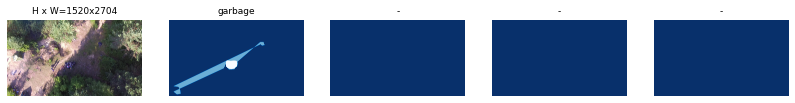

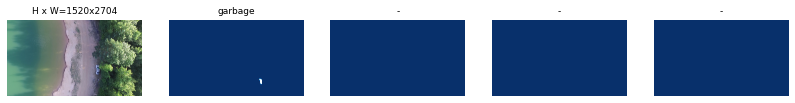

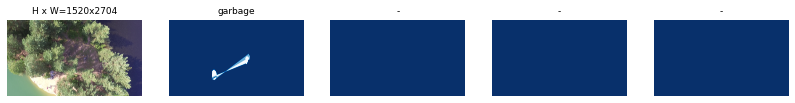

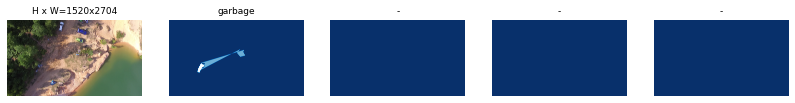

In [33]:
# Load and display random samples
image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)

    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

(1520, 2704, 3)


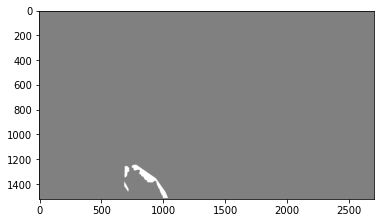

In [34]:
image_id = 5
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)

plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()

In [7]:
# Directory to save logs and trained model
ROOT = "D:/PythonProjects/Red_scull-ML-Hackaton/datasets"

MODEL_DIR = ROOT + "/logs"

# Local path to trained weights file
COCO_MODEL_PATH = ROOT + "/mask_rcnn_coco.h5"
print(os.getcwd())

D:\PythonProjects\Red_scull-ML-Hackaton


In [8]:
class GarbageConfig(Config):
    NAME = "garbage"
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 131
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

config = GarbageConfig()

In [9]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [10]:
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [11]:
model.train(train_set, validate_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:/PythonProjects/Red_scull-ML-Hackaton/datasets/logs\garbage20211031T0302\mask_rcnn_garbage_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistr

d:\pythonprojects\red_scull-ml-hackaton\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
d:\pythonprojects\red_scull-ml-hackaton\venv\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
d:\pythonprojects\red_scull-ml-hackaton\venv\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting s

  4/131 [..............................] - ETA: 4:00:42 - batch: 1.5000 - size: 8.0000 - loss: 3.8292 - rpn_class_loss: 0.1546 - rpn_bbox_loss: 0.8634 - mrcnn_class_loss: 1.2607 - mrcnn_bbox_loss: 0.9073 - mrcnn_mask_loss: 0.6432  

KeyboardInterrupt: 

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")